In [1]:
# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox

In [2]:
random.seed(3)

In [3]:
# Imports for better visualization
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

## Importing Data

In [4]:
train=pd.read_csv(r"C:\Users\HARSH\Desktop\AMEX\Data\Training_Dataset.csv")
test=pd.read_csv(r"C:\Users\HARSH\Desktop\AMEX\Data\Final_Dataset.csv")

In [5]:
train.shape

(40000, 52)

In [6]:
data=pd.concat([train, test])

In [7]:
data.shape, train.shape, test.shape

((50000, 52), (40000, 52), (10000, 46))

## Creating target variable

In [8]:
data["Y"] = abs(data.mvar49)
train["Y"] = abs(train.mvar49)

In [9]:
data["Y"].value_counts()

0.0    36553
1.0     3447
Name: Y, dtype: int64

In [10]:
del data["mvar46"]
del data["mvar47"]
del data["mvar48"]
del data["mvar49"]
del data["mvar50"]
del data["mvar51"]

## Pre-processing and Feature Engineering

In [11]:
# Missing values in mvar3 were imputed with median after grouping down the data according to Family size.
data["mvar3"][data.mvar3 == 0] = np.nan
data["mvar3"] = data.groupby("mvar2").mvar3.transform(lambda x: x.fillna(x.median()))

In [12]:
# Dataset contains many variables which are very skewed so those variables were normalized using box-cox transformations
# Upper cap is set to 99 percentile of its value
# Boosting model tend to perform poorly when values of single type occur many times in a single columns
# so to compensate that random noise was also added to continuous features.
skewed = ["mvar3", "mvar9", 
          "mvar16", "mvar17", "mvar18", "mvar19",
          "mvar20", "mvar21", "mvar22", "mvar23",
          "mvar24", "mvar25", "mvar26", "mvar27",
          "mvar28", "mvar29", "mvar30", "mvar31",
          "mvar32", "mvar33", "mvar34", "mvar35",
          "mvar36", "mvar37", "mvar38", "mvar39"]

def normalizing(X):
    data[X][data[X] < 0]=0
    data[X][data[X] > data[X].quantile(0.99)] = data[X].quantile(0.99)
    data[X] = data[X].apply(lambda x: x+np.random.rand())
    
    data[X] = data[X].apply(lambda x: x+1)
    data[X], _ = boxcox(data[X])

for i in skewed:
    normalizing(i)

In [13]:
# categorical = ["mvar12"]

# for i in categorical:
#     dummy = pd.get_dummies(data[i], prefix=i)
#     data = pd.concat([data, dummy], axis=1)
# #     data.drop([i], axis=1, inplace=True)

In [14]:
categorical = ["mvar12", "mvar2"]

def replacing_categorical(X):
    x=train.groupby(X)["Y"].mean()
    y=train.groupby(X)["Y"].std()
    data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#     data[X+str("_std")] = data[X].apply(lambda X2: y[X2])
#     del data[X]

for i in categorical:
    replacing_categorical(i)

In [16]:
data['electronics'] =  data.mvar16 + data.mvar17 + data.mvar18 + data.mvar19 
data['travel'] =  data.mvar21 + data.mvar22 + data.mvar23 + data.mvar20 
data['household'] =  data.mvar25 + data.mvar26 + data.mvar27 + data.mvar24
data['car'] =  data.mvar29 + data.mvar30 + data.mvar31 + data.mvar28
data['retail'] =  data.mvar33 + data.mvar34 + data.mvar35 + data.mvar32
data['total'] =  data.mvar36 + data.mvar37 + data.mvar38 + data.mvar39 

data['total_internal_score'] = data.mvar7 + data.mvar8 + data.mvar11/7
data['fees_per_club'] =  (data.mvar6*1.0)/data.mvar14
data['spending_per_member'] =  (data.mvar3*1.0)/data.mvar2

## Model Making

In [17]:
train_new = data.iloc[0:train.shape[0]]
test_new = data.iloc[train.shape[0]:data.shape[0]]

In [18]:
train_new.shape, test_new.shape

((40000, 49), (10000, 49))

In [19]:
#Preparing data
def prepare_data(df, is_train):
    
    # Dropping cm_key
    df = df.drop(["cm_key"], axis=1)
    
    # Dropping mvar1 due to uniformity
    df  = df.drop(["mvar1"], axis=1)
    
    if is_train:
        return df.drop([ 'mvar12',"Y"], axis=1), df['Y']
    return     df.drop([ 'mvar12',"Y"], axis=1)

In [20]:
train_features, train_target =prepare_data(train_new, 1)
test_features = prepare_data(test_new,0)

In [21]:
train_features.shape, test_features.shape

((40000, 45), (10000, 45))

In [22]:
import xgboost
from sklearn.cross_validation import train_test_split

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

C:\Users\HARSH\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target, stratify=train_target,
                                                test_size=.3, random_state=100 )

In [24]:
xgb = XGBClassifier(n_estimators=500, seed=100)
xgb.fit(Xtrain, ytrain )

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=100, silent=True, subsample=1)

In [25]:
print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))

Training :0.921714285714
Test :0.91425
ROC_AUC :0.515994664006
precision_score :0.537313432836
recall_score :0.0348162475822


In [26]:
confusion_matrix(ytest, xgb.predict(Xtest))

array([[10935,    31],
       [  998,    36]])

In [27]:
def myscorer(cm):
    False1 = cm[0][1]
    False2 = cm[1][0]
    return (3*False1) + (False2), (False1+False2)

In [28]:
myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))

(1091, 1029)

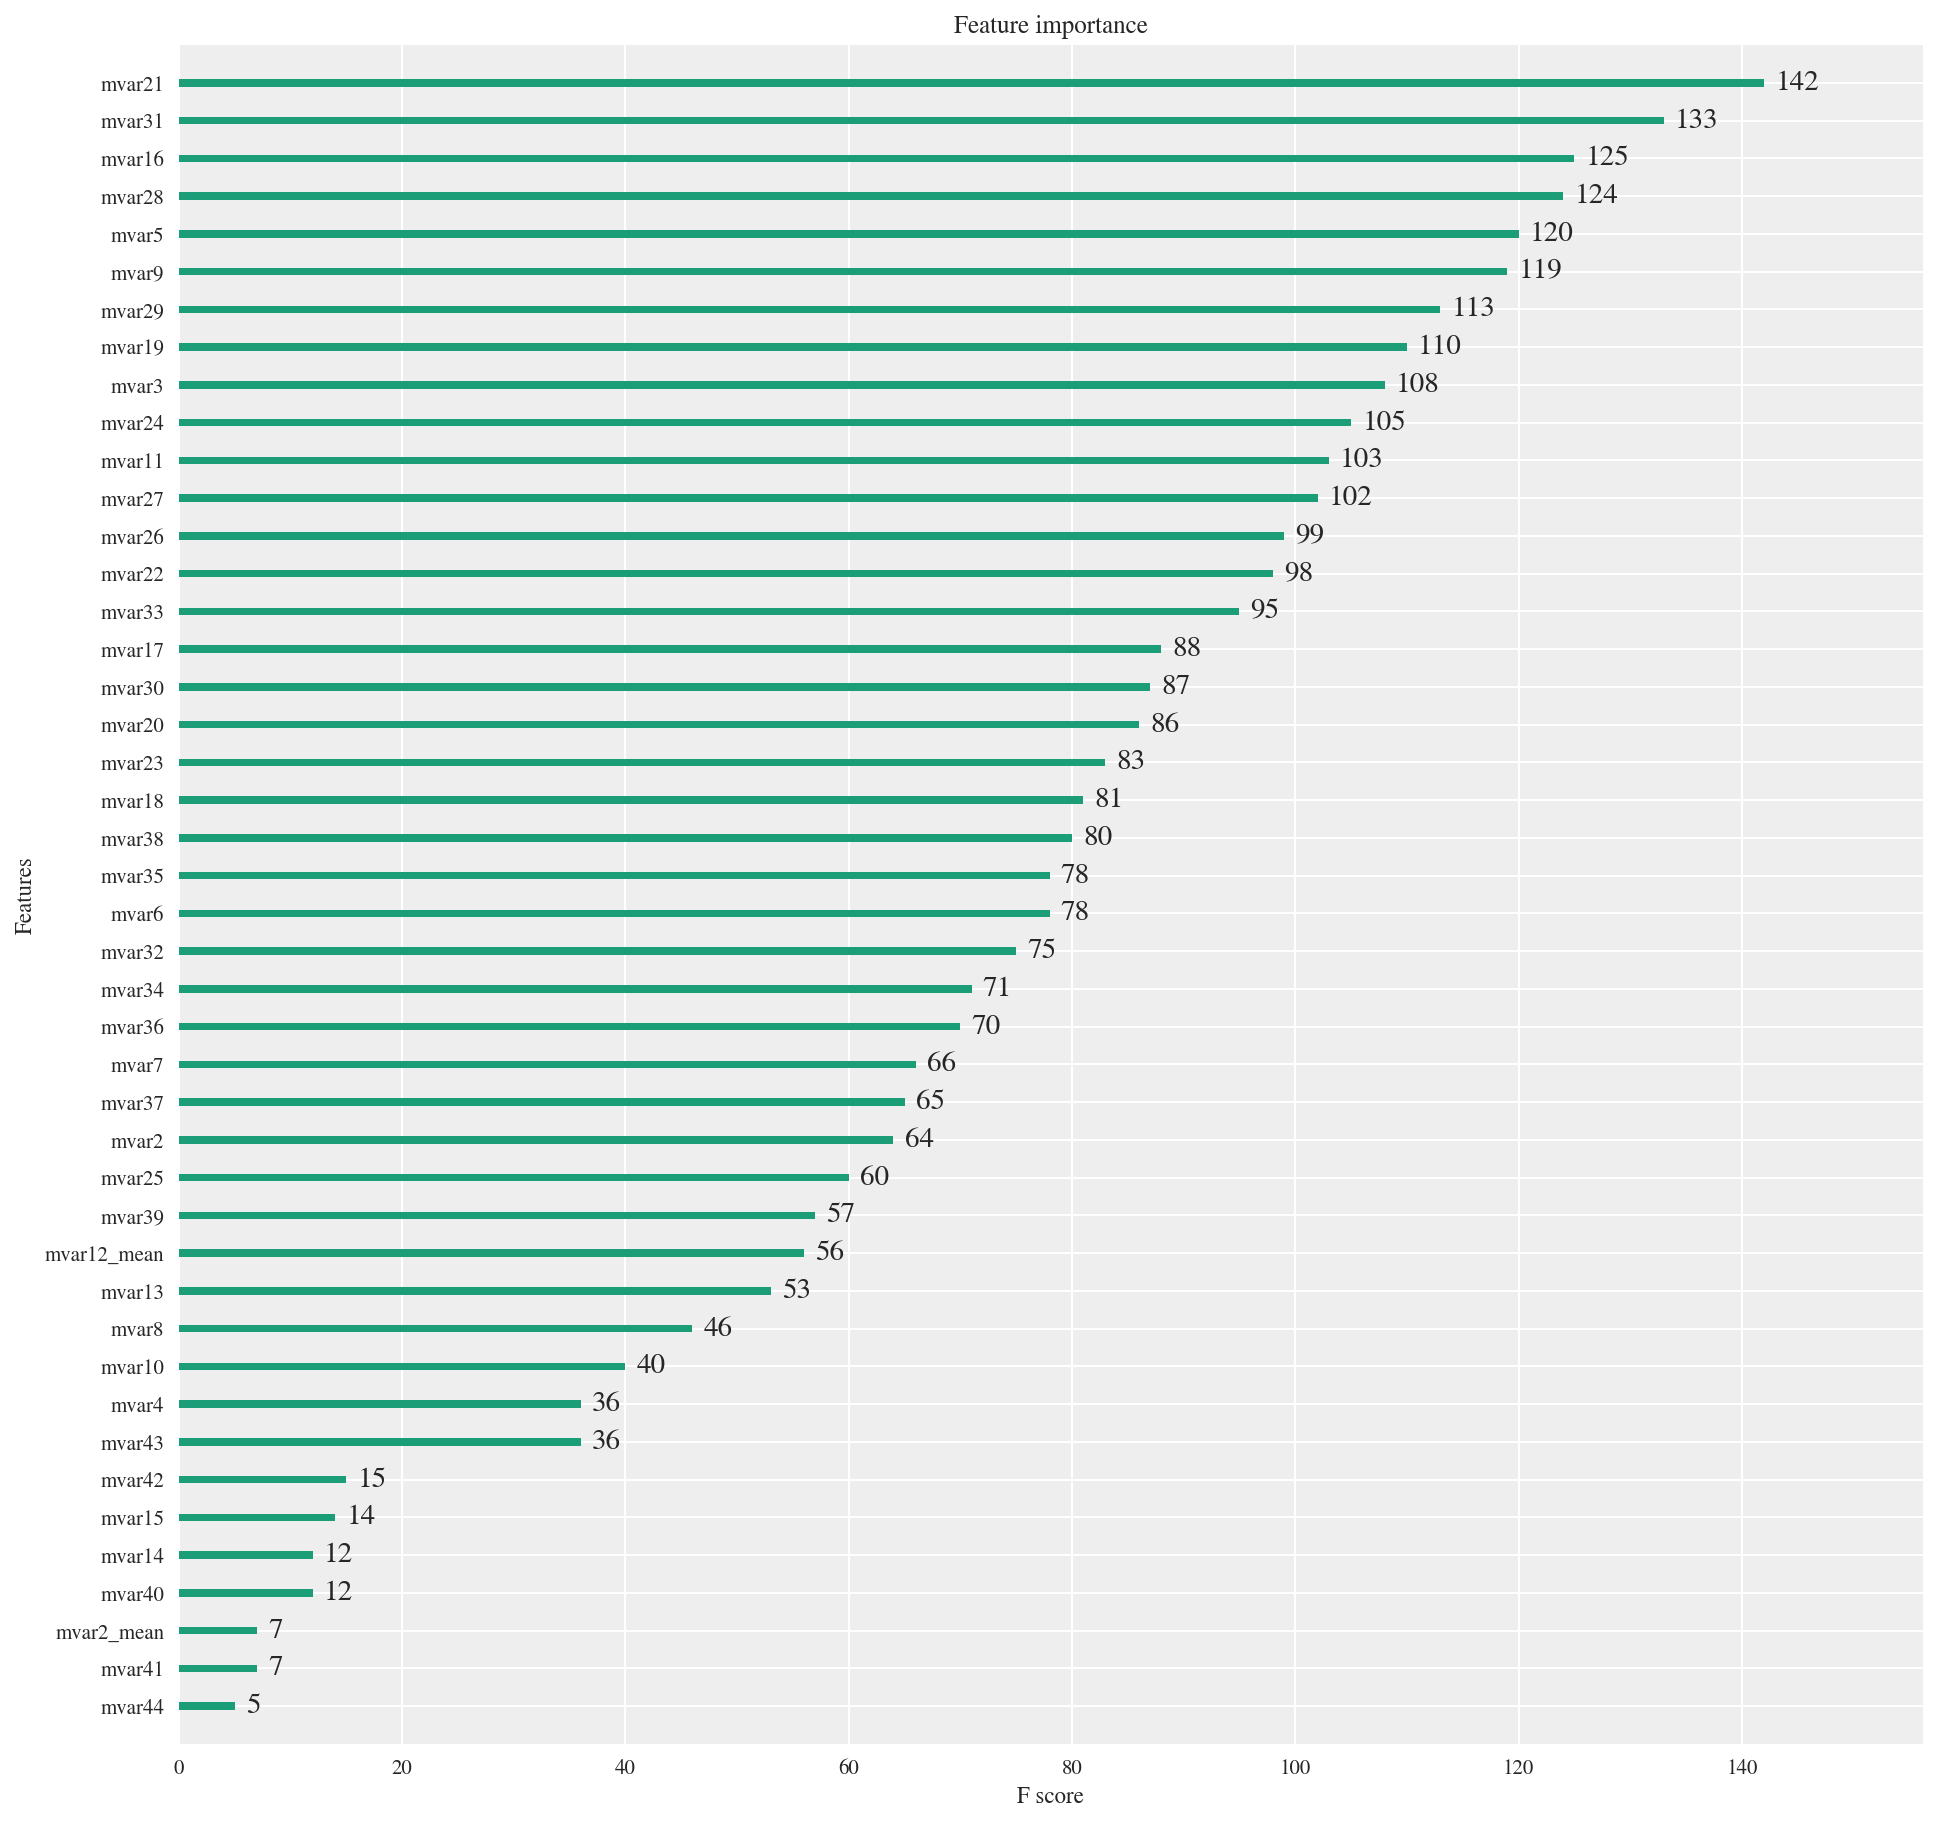

In [29]:
ax = xgboost.plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(15, 15)

In [30]:
# Training on whole data
xgb.fit(train_features, train_target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=100, silent=True, subsample=1)

In [31]:
submission = pd.concat([test["cm_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["Supp_NO","Supp_Yes"])], axis=1)
submission.to_csv(r"C:\Users\HARSH\Desktop\AMEX\COmbining\Supp.csv", index=False)

In [32]:
np.sum(xgb.predict(test_features))

62.0

In [33]:
xgb.predict_proba(test_features)

array([[ 0.94469243,  0.05530757],
       [ 0.95059514,  0.04940484],
       [ 0.95784646,  0.04215354],
       ..., 
       [ 0.92943352,  0.07056649],
       [ 0.9489885 ,  0.05101149],
       [ 0.93155563,  0.06844436]], dtype=float32)

In [34]:
xgb.predict(test_features)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])